__Author:__ Andrew Lesak - 11/02/23

__Purpose:__ Make videos demonstrating each state for the prey capture data

# Imports
____

In [1]:
# run 'pip install library_name' if you dont have a library installed
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy import signal
from distinctipy import distinctipy
from itertools import groupby
from operator import itemgetter
from pathlib import Path

# libraries for movies & tiling movies
import cv2 as cv
from moviepy.editor import VideoFileClip, clips_array

# Load data
____

Get file path for data

In [2]:
path        = "/home/alesak/alesak/preycaptureHMM_updated/"
df_name     = "ARHMM_5states_full_df.pkl"
lag_df_name = "ARHMM_5states_lagged_downsampled_df.pkl"

Specify the num of states

In [3]:
num_states = 5

Load dataframes

In [4]:
df = pd.read_pickle(path + df_name)
lag_df = pd.read_pickle(path + lag_df_name)

View IDs

In [5]:
trial_ids = df["trial_ID"].unique().tolist()
print("Current IDs:",trial_ids)

Current IDs: [51, 52, 53, 54, 55, 56, 57, 59, 60, 61, 62, 63, 64, 66, 67, 68, 69, 70, 71, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 175, 176, 177, 178, 179, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 230, 231, 232, 233, 235, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 268, 269, 270, 273, 274, 275, 276, 277, 2

# Make movies demonstrating each state
___

## Load movie & get frames

In [6]:
def load_mov_get_frames(vid_path,vid_name):
    """
    Loads movie and returns list of frames.
    """
    # get movie
    mov = cv.VideoCapture(vid_path + vid_name)
    # print FPS of video & num frames
    fps = mov.get(5)    
    print('Frames per second : ', fps,'FPS')
    frame_count = mov.get(7)
    print('Frame count : ', frame_count)
    # get frames
    count = 0
    mov_frames = []
    while(mov.isOpened()):
        success, image = mov.read() # mov.read() returns a tuple, first element is a bool, second is frame
        print('Frame: {}/{}'.format(count,int(frame_count)),end='\r')
        mov_frames.append(image)
        count += 1
        if success:
            key = cv.waitKey(1) # milliseconds to wait
            if key == ord('q'): break
        else: break
        
    # Release the video capture object
    mov.release()
    cv.destroyAllWindows()

    return mov_frames

In [7]:
# select trial num
trial_num = 211

# get path for trial video
vid_path = "/home/alesak/alesak/preycaptureHMM_updated/"
vid_name = "trial_ID_{}.mp4".format(trial_num)
# get frames
mov_frames = load_mov_get_frames(vid_path,vid_name)

Frames per second :  199.9 FPS
Frame count :  12628.0


## Plot a frame with overlaid data because why not

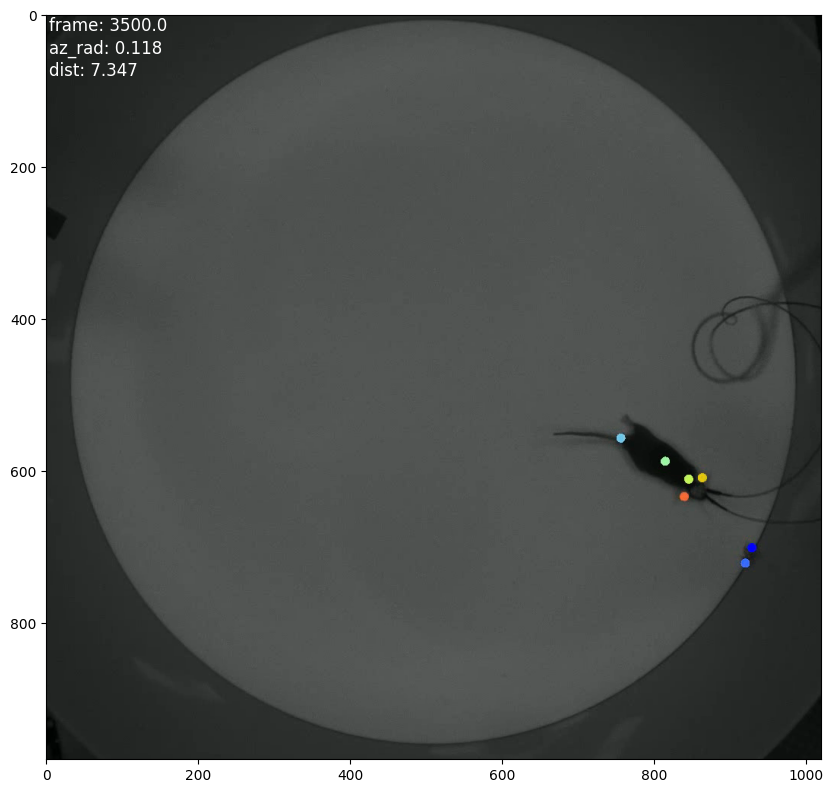

In [9]:
# select frame to plot
frame_num = 3500

# select data for frame
t_frame_sel = (df["trial_ID"]==trial_num) & (df["frame"]==frame_num)

# plot frame
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(mov_frames[frame_num][50:-50,250:-170])

# display variable values
x, y = 3,20
step = 30 # y gap b/w lines of text
d = 3 # decimal places to round
vars_to_display = ["frame","az_rad","dist"] # list which vars in 'df' to display
for i,v in enumerate(vars_to_display):
    ax.text(x,y+i*step,s=v + ": {}".format(round(df[t_frame_sel][v].iloc[0],d)),color="white",size='large')

plt.show()

## Get clips of each state from a given trial

### Get frame sequences in which the mouse is in a given state

In [10]:
def get_state_sequence_start_stop_frames(df,trial_num,num_states=num_states):
    """
    This function returns a list of tuples of the start & end frames in which the mouse is in a given state. 
    This list is sorted by duration.
    """
    trial_sel = (df["trial_ID"]==trial_num)

    # get trial state sequence & frame numbers
    trial_states = np.array(df[trial_sel]["state"],dtype=float)
    trial_frames = np.array(df[trial_sel]["frame"],dtype=float)

    # get all repeated sequences of the same state with corresponding frame nums
    counter = np.arange(1, len(trial_states))
    state_seqs = np.split(trial_states, counter[trial_states[1:]!=trial_states[:-1]])
    frame_seqs = np.split(trial_frames, counter[trial_states[1:]!=trial_states[:-1]])

    # make lists to store info by state 
    seqs_by_state    = [[] for _ in range(num_states)]
    frames_by_state  = [[] for _ in range(num_states)]
    seq_len_by_state = [[] for _ in range(num_states)]

    num_seqs = len(state_seqs)
    for i in range(num_seqs):
        # get state num in repeated sequence
        s = int(np.unique(state_seqs[i])[0]) 
        # append stuff to lists
        seqs_by_state[s].append(state_seqs[i])
        frames_by_state[s].append(frame_seqs[i])
        seq_len_by_state[s].append(len(state_seqs[i]))

    # sort state sequences by duration (longest --> shortest)
    state_seq_frames_by_dur = [[] for _ in range(num_states)]
    for s in range(num_states):
        # get lens of each sequence of state s
        curr_lens = np.array(seq_len_by_state[s])
        # sort from low to high and reverse indices
        idx = np.argsort(curr_lens)[::-1]
        # get frames that correspond with each sequence ordered by duration of seq
        curr_seq_frames_by_state = np.array(frames_by_state[s],dtype=object)
        state_seq_frames_by_dur[s].append(curr_seq_frames_by_state[idx])
    
    # get only start/end frame tuple for each sequence
    seq_start_stop_frames_by_state = [[] for _ in range(num_states)]
    for s in range(num_states):
        state_seqs = state_seq_frames_by_dur[s][0]
        n_seqs = len(state_seqs)
        for j in range(n_seqs):
            if len(state_seqs[j]) > 1: # only record if theres more than 1 frame
                seq_start_stop_frames_by_state[s].append((min(state_seqs[j]),max(state_seqs[j])))

    return seq_start_stop_frames_by_state

In [11]:
state_seq_start_stop_frames = get_state_sequence_start_stop_frames(lag_df,trial_num=trial_num)

### Make movies

In [12]:
# specify directory in which to save video clips
clip_dir = "/home/alesak/alesak/preycaptureHMM_updated/state_clips_trial{}/".format(trial_num)

# select the num. of clips to make for each state
num_to_plot = 4

# specify FPS of trial data
FPS = 200

In [13]:
# Obtain frame size information
frame_width  = mov_frames[0].shape[1]
frame_height = mov_frames[0].shape[0]
frame_size   = (frame_width,frame_height)

# make movies
for i in range(num_states):
    print("State: {}/{}".format(i,num_states-1),end='\r')
    seq_start_stop_frames = state_seq_start_stop_frames[i]
    n_seqs = len(seq_start_stop_frames)
    if n_seqs>0:
        for j in range(min(n_seqs,num_to_plot)):
            # prepare to write frames to video
            save_path = clip_dir + "ex_state{}_seq{}.mp4".format(i,j)
            output = cv.VideoWriter(save_path, cv.VideoWriter_fourcc(*'mp4v'), FPS, frame_size)

            # get all frames to plot
            start = int(seq_start_stop_frames[j][0])           
            stop  = int(seq_start_stop_frames[j][1])
            frames_to_plot = np.arange(start,stop)
        
            # make video
            for frame in frames_to_plot:
                output.write(mov_frames[frame])

            # release the object
            output.release()

### Make 'null' video thats just empty

Kind of a dumb fix but we will just show this black screen for when we are tiling videos and we are missing some states or clips or something.

In [14]:
empty_frames = [np.uint8(np.zeros((frame_height,frame_width,3)))]

# prepare to write frames to video
save_path = clip_dir + "null.mp4"
output = cv.VideoWriter(save_path, cv.VideoWriter_fourcc(*'mp4v'), FPS, frame_size)

# get the frames to plot
frames_to_plot = np.array([0])

# make video
for frame in frames_to_plot:
    output.write(empty_frames[frame])

# release the object
output.release()

# Tile videos
___

## Tile longest clip of each state into one video

Get the longest clip for each state within the current trial. If no clip exists for a given state, we append a video of an empty frame.

In [15]:
# select downsample ratio b/w 0 & 1
dsr = 0.60

# lets first get the null_vid ready in case we need it
null_path = clip_dir + "null.mp4" 
null_vid = VideoFileClip(null_path,audio=False).resize(dsr)

# get vids for each state
vids = []
for s in range(num_states):
    state_clip_path = clip_dir + "ex_state{}_seq0.mp4".format(s)
    if Path(state_clip_path).is_file(): # check if path exists
        vid = VideoFileClip(state_clip_path,audio=False).resize(dsr)
        vids.append(vid)
    else: # if path doesnt exist, append empty vid
        vids.append(null_vid)

Specify how many rows & columns we want to have in our tiled vid. For 10 states, we can go with 2 rows of 5 columns. If we had 11 states, then we could do something like 3 rows of 4 columns, but append the empty vid in the extra slot(s). 

In [16]:
# select num of rows & cols
n_rows = 2
n_cols = 3
# make sure there is enough room for all states
assert n_rows*n_cols >= num_states

# make clips_array where we tile each video
final_clip = [[] for _ in range(n_rows)]
for row in range(n_rows):
    for i in range(n_cols):
        state = i + row*n_cols
        if state < num_states: 
            final_clip[row].append(vids[state])
        else: 
            final_clip[row].append(null_vid)

final_clip = clips_array(final_clip)

Make the tiled movie

In [17]:
# specify name and downsample ratio
name = "tiled_all_state_clips.mp4"
tile_dsr = 0.5 # for large num of states, need to really downsample otherwise video struggles to play

# make the video
final_clip.resize(tile_dsr).write_videofile(clip_dir + name)

Moviepy - Building video /home/alesak/alesak/preycaptureHMM_updated/state_clips_trial211/tiled_all_state_clips.mp4.
Moviepy - Writing video /home/alesak/alesak/preycaptureHMM_updated/state_clips_trial211/tiled_all_state_clips.mp4



Moviepy - Done !
Moviepy - video ready /home/alesak/alesak/preycaptureHMM_updated/state_clips_trial211/tiled_all_state_clips.mp4


## Tile clips within the same state together

In [24]:
# select downsample ratio b/w 0 & 1
dsr = 0.60
# select the number of clips to plot (specified earlier when we made the clips)
num_to_plot = 4

# lets first get the null_vid ready in case we need it
null_path = clip_dir + "null.mp4" 
null_vid = VideoFileClip(null_path,audio=False).resize(dsr)

# get vids
vids_by_state = [[] for _ in range(num_states)]
for s in range(num_states):
    # get vids for each state
    for i in range(num_to_plot):
        state_clip_path = clip_dir + "ex_state{}_seq{}.mp4".format(s,i)
        if Path(state_clip_path).is_file(): # check if path exists
            vid = VideoFileClip(state_clip_path,audio=False).resize(dsr)
            vids_by_state[s].append(vid)
        else: # if path doesnt exist, append empty vid
            vids_by_state[s].append(null_vid)

In [25]:
# select num of rows & cols
n_rows = 2
n_cols = 2

# make sure there is enough room for all clips
assert n_rows*n_cols >= num_to_plot

# use loop to make tiled vid for each state
for s in range(num_states):
    print("State: {}/{}".format(s,num_states-1))
    # make clips_array where we tile each video
    final_clip = [[] for _ in range(n_rows)]
    for row in range(n_rows):
        for i in range(n_cols):
            clip = i + row*n_cols
            if clip < num_to_plot: 
                final_clip[row].append(vids_by_state[s][clip])
            else: 
                final_clip[row].append(null_vid)
    final_clip = clips_array(final_clip)

    # specify name and downsample ratio
    name = "tiled_state{}_clips.mp4".format(s)
    tile_drs = 0.5

    # make the video
    final_clip.resize(tile_drs).write_videofile(clip_dir + name)

Moviepy - Building video /home/alesak/alesak/preycaptureHMM_updated/state_clips_trial211/tiled_state0_clips.mp4.
Moviepy - Writing video /home/alesak/alesak/preycaptureHMM_updated/state_clips_trial211/tiled_state0_clips.mp4



Moviepy - Done !
Moviepy - video ready /home/alesak/alesak/preycaptureHMM_updated/state_clips_trial211/tiled_state0_clips.mp4
Moviepy - Building video /home/alesak/alesak/preycaptureHMM_updated/state_clips_trial211/tiled_state1_clips.mp4.
Moviepy - Writing video /home/alesak/alesak/preycaptureHMM_updated/state_clips_trial211/tiled_state1_clips.mp4



Moviepy - Done !
Moviepy - video ready /home/alesak/alesak/preycaptureHMM_updated/state_clips_trial211/tiled_state1_clips.mp4
Moviepy - Building video /home/alesak/alesak/preycaptureHMM_updated/state_clips_trial211/tiled_state2_clips.mp4.
Moviepy - Writing video /home/alesak/alesak/preycaptureHMM_updated/state_clips_trial211/tiled_state2_clips.mp4



Moviepy - Done !
Moviepy - video ready /home/alesak/alesak/preycaptureHMM_updated/state_clips_trial211/tiled_state2_clips.mp4
Moviepy - Building video /home/alesak/alesak/preycaptureHMM_updated/state_clips_trial211/tiled_state3_clips.mp4.
Moviepy - Writing video /home/alesak/alesak/preycaptureHMM_updated/state_clips_trial211/tiled_state3_clips.mp4



Moviepy - Done !
Moviepy - video ready /home/alesak/alesak/preycaptureHMM_updated/state_clips_trial211/tiled_state3_clips.mp4
Moviepy - Building video /home/alesak/alesak/preycaptureHMM_updated/state_clips_trial211/tiled_state4_clips.mp4.
Moviepy - Writing video /home/alesak/alesak/preycaptureHMM_updated/state_clips_trial211/tiled_state4_clips.mp4



Moviepy - Done !
Moviepy - video ready /home/alesak/alesak/preycaptureHMM_updated/state_clips_trial211/tiled_state4_clips.mp4
Moviepy - Building video /home/alesak/alesak/preycaptureHMM_updated/state_clips_trial211/tiled_state5_clips.mp4.
Moviepy - Writing video /home/alesak/alesak/preycaptureHMM_updated/state_clips_trial211/tiled_state5_clips.mp4



Moviepy - Done !
Moviepy - video ready /home/alesak/alesak/preycaptureHMM_updated/state_clips_trial211/tiled_state5_clips.mp4
Moviepy - Building video /home/alesak/alesak/preycaptureHMM_updated/state_clips_trial211/tiled_state6_clips.mp4.
Moviepy - Writing video /home/alesak/alesak/preycaptureHMM_updated/state_clips_trial211/tiled_state6_clips.mp4



Moviepy - Done !
Moviepy - video ready /home/alesak/alesak/preycaptureHMM_updated/state_clips_trial211/tiled_state6_clips.mp4
Moviepy - Building video /home/alesak/alesak/preycaptureHMM_updated/state_clips_trial211/tiled_state7_clips.mp4.
Moviepy - Writing video /home/alesak/alesak/preycaptureHMM_updated/state_clips_trial211/tiled_state7_clips.mp4



Moviepy - Done !
Moviepy - video ready /home/alesak/alesak/preycaptureHMM_updated/state_clips_trial211/tiled_state7_clips.mp4
Moviepy - Building video /home/alesak/alesak/preycaptureHMM_updated/state_clips_trial211/tiled_state8_clips.mp4.
Moviepy - Writing video /home/alesak/alesak/preycaptureHMM_updated/state_clips_trial211/tiled_state8_clips.mp4



Moviepy - Done !
Moviepy - video ready /home/alesak/alesak/preycaptureHMM_updated/state_clips_trial211/tiled_state8_clips.mp4
Moviepy - Building video /home/alesak/alesak/preycaptureHMM_updated/state_clips_trial211/tiled_state9_clips.mp4.
Moviepy - Writing video /home/alesak/alesak/preycaptureHMM_updated/state_clips_trial211/tiled_state9_clips.mp4



Moviepy - Done !
Moviepy - video ready /home/alesak/alesak/preycaptureHMM_updated/state_clips_trial211/tiled_state9_clips.mp4


At this point you can delete all of the individual clips since we dont need them anymore. Probably would be more resourceful to figure out how to make the tiled videos without saving each clip first... maybe I'll fix that one day.